In [1]:
from utils import *
from sklearn import metrics
import pandas as pd
plt.style.use('default')
plt.rc('font', size=16, family='serif')
plt.rc('mathtext', default='it', fontset='cm')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Experiment runner

In [2]:
def real_experiment(data, depths, alpha=1e-5):
    """
    Data format := `[X_train, y_train, X_test, y_test, norm : bool, noise : bool, name : str]`

    Outputs dictionary containing `dataset`, `means`, `kernel`, 
    `ntk`, `lap`, and `gaus` information
    """
    norm = data[-3]
    noise = data[-2]
    name = data[-1]

    print(f'\n{name} :\nnorm  = {norm}\nnoise = {noise}\ndepth = {depths}')

    exp_data = {}
    exp_data['kernel'] = {}
    exp_data['metrics'] = {}

    means_n = []
    for depth in depths:


        #########################
        # Neural tangent Kernel #
        #########################


        ntk = (
            ConstantKernel(constant_value=1) + 
            NTK(depth=depth, bias=0.1)
        )

        if noise:
            ntk += WhiteKernel(noise_level=0.1)

        gp_n = GPR(kernel=ntk, alpha=alpha, normalize_y=True,
            n_restarts_optimizer=9, random_state=29834057)

        gp_n.fit(data[0], data[1])
        mean_n = gp_n.predict(data[2])
        print(gp_n.kernel_)


        #########################
        #         Data          #
        #########################


        if noise: 
            const_val_n = gp_n.kernel_.get_params()['k1__k1__constant_value']
            noise_lvl_n = gp_n.kernel_.get_params()['k2__noise_level']
            bias = gp_n.kernel_.get_params()['k1__k2__bias']
        else:
            const_val_n = gp_n.kernel_.get_params()['k1__constant_value']
            noise_lvl_n = None
            bias = gp_n.kernel_.get_params()['k2__bias']

        means_n.append(mean_n.ravel())

        exp_data['kernel'][f'ntk_{depth}'] = {
                'C' : const_val_n,
                'W' : noise_lvl_n,
                'depth' : depth,
                'bias' : bias
            }
        
        exp_data['metrics'][f'ntk_{depth}'] = {
                'rmse' : metrics.mean_squared_error(data[3].ravel(), mean_n.ravel(), squared=False),
                'r2' : metrics.r2_score(data[3].ravel(), mean_n.ravel())
            }




    #########################
    #   Lap + Gaus Kernel   #
    #########################    


    lap = (
        ConstantKernel(constant_value=1) + 
        Matern(nu=1/2, length_scale=1)
    )

    gaus = (
        ConstantKernel(constant_value=1) + 
        Matern(nu=np.inf, length_scale=1)
    )

    if noise:
        lap += WhiteKernel(noise_level=0.1)
        gaus += WhiteKernel(noise_level=0.1)


    gp_l = GPR(kernel=lap, alpha=alpha, normalize_y=True,
        n_restarts_optimizer=9, random_state=29834057)

    gp_g = GPR(kernel=gaus, alpha=alpha, normalize_y=True,
        n_restarts_optimizer=9, random_state=29834057)


    gp_l.fit(data[0], data[1])
    mean_l = gp_l.predict(data[2])
    print(gp_l.kernel_)

    gp_g.fit(data[0], data[1])
    mean_g = gp_g.predict(data[2])
    print(gp_g.kernel_)


    #########################
    #         Data          #
    #########################


    if noise: 
        const_val_l = gp_l.kernel_.get_params()['k1__k1__constant_value']
        const_val_g = gp_g.kernel_.get_params()['k1__k1__constant_value']

        noise_lvl_l = gp_l.kernel_.get_params()['k2__noise_level']
        noise_lvl_g = gp_g.kernel_.get_params()['k2__noise_level']

        ell_l = gp_l.kernel_.get_params()['k1__k2__length_scale']
        ell_g = gp_g.kernel_.get_params()['k1__k2__length_scale']
    else:
        const_val_l = gp_l.kernel_.get_params()['k1__constant_value']
        const_val_g = gp_g.kernel_.get_params()['k1__constant_value']

        noise_lvl_l = None
        noise_lvl_g = None
        
        ell_l = gp_l.kernel_.get_params()['k2__length_scale']
        ell_g = gp_g.kernel_.get_params()['k2__length_scale']


    exp_data['dataset'] = {
        'name' : name, 
        'norm' : norm,
        'noise': noise,
        'test' : [data[2], data[3]]
    }

    exp_data['means'] = (*means_n, mean_l.ravel(), mean_g.ravel())


    exp_data['kernel']['lap'] = {
            'C' : const_val_l,
            'W' : noise_lvl_l,
            'ell' : ell_l
        }
    exp_data['kernel']['gaus'] = {
            'C' : const_val_g,
            'W' : noise_lvl_g,
            'ell' : ell_g
        }
    exp_data['metrics']['lap'] = {
            'rmse' : metrics.mean_squared_error(data[3].ravel(), mean_l.ravel(), squared=False),
            'r2' : metrics.r2_score(data[3].ravel(), mean_l.ravel())
        }
    exp_data['metrics']['gaus'] = {
            'rmse' : metrics.mean_squared_error(data[3].ravel(), mean_g.ravel(), squared=False),
            'r2' : metrics.r2_score(data[3].ravel(), mean_g.ravel())
        }

    return exp_data

# Datasets

In [3]:
# [X_train, y_train, X_test, y_test, norm : bool, noise : bool, name : str]
datasets = []

In [4]:
concrete = pd.read_csv('./real_world_data/concrete.csv', header=0)

names_c = concrete.columns

X = concrete.drop(names_c[-1], axis=1)
X = X.to_numpy()
y = concrete[names_c[-1]]
y = y.to_numpy()

X_t = np.zeros_like(X)
for i in range(0, X.shape[1]):
    X_t[:,i] = (X[:,i] - np.mean(X[:,i])) / np.std(X[:,i])

y_t = y

X_train, X_test, y_train, y_test = train_test_split(X_t, y_t, test_size=0.25, random_state=13450978)

datasets.append([X_train, y_train, X_test, y_test, False, False, 'Concrete'])
datasets.append([X_train, y_train, X_test, y_test, False, True, 'Concrete'])

X_train, X_test, y_train, y_test = train_test_split(normalize(X_t, axis=1), y_t, test_size=0.25, random_state=13450978)

datasets.append([X_train, y_train, X_test, y_test, True, False, 'Concrete'])
datasets.append([X_train, y_train, X_test, y_test, True, True, 'Concrete'])

In [74]:
forest_fires = pd.read_csv('./real_world_data/forestfires.csv', header=0)
# forest_fires.drop(['month', 'day'], axis=1, inplace=True)
# forest_fires.drop(['month', 'day', 'X', 'Y'], axis=1, inplace=True)
forest_fires.drop(['month', 'day', 'X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI'], axis=1, inplace=True)

names_f = forest_fires.columns

X = forest_fires.drop('area', axis=1)
print(X)
X = X.to_numpy()
X_forest = X
y = forest_fires['area']
y = y.to_numpy()

X_t = np.zeros_like(X)
for i in range(0, X.shape[1]):
    X_t[:,i] = (X[:,i] - np.mean(X[:,i])) / np.std(X[:,i])

y_t = np.log(y + 1)

_, X_forest_test, _, _ = train_test_split(X_forest, y_t, test_size=0.25, random_state=13450978)
X_train, X_test, y_train, y_test = train_test_split(X_t, y_t, test_size=0.25, random_state=13450978)

print(X_forest_test.shape)
print(X_test.shape)

datasets.append([X_train, y_train, X_test, y_test, False, False, 'Fires'])
datasets.append([X_train, y_train, X_test, y_test, False, True, 'Fires'])

X_train, X_test, y_train, y_test = train_test_split(normalize(X_t, axis=1), y_t, test_size=0.25, random_state=13450978)

datasets.append([X_train, y_train, X_test, y_test, True, False, 'Fires'])
datasets.append([X_train, y_train, X_test, y_test, True, True, 'Fires'])

     temp  RH  wind  rain
0     8.2  51   6.7   0.0
1    18.0  33   0.9   0.0
2    14.6  33   1.3   0.0
3     8.3  97   4.0   0.2
4    11.4  99   1.8   0.0
..    ...  ..   ...   ...
512  27.8  32   2.7   0.0
513  21.9  71   5.8   0.0
514  21.2  70   6.7   0.0
515  25.6  42   4.0   0.0
516  11.8  31   4.5   0.0

[517 rows x 4 columns]
(130, 4)
(130, 4)


NameError: name 'datasets' is not defined

# Results

In [35]:
depths = (2, 3, 10)
arrays = [
    ["Concrete", "Fires"],
    ['RMSE', r'$R^2$'],
    [r'$\R$', r'$\Ss$'],
    ['No', 'Yes'],  # Noise
]

index = pd.MultiIndex.from_product(
    arrays, names=['Dataset', 'Metric', 'Space', 'Noise'])


df = pd.DataFrame(
    index=index,
    columns=['NTK D=2', 'NTK D=3', 'NTK D=10', 'Laplace', 'Gaussian']
)

df

NTK D=2 NTK D=3 NTK D=10 Laplace Gaussian
Dataset  Metric Space Noise                                          
Concrete RMSE   $\R$  No        NaN     NaN      NaN     NaN      NaN
                      Yes       NaN     NaN      NaN     NaN      NaN
                $\Ss$ No        NaN     NaN      NaN     NaN      NaN
                      Yes       NaN     NaN      NaN     NaN      NaN
         $R^2$  $\R$  No        NaN     NaN      NaN     NaN      NaN
                      Yes       NaN     NaN      NaN     NaN      NaN
                $\Ss$ No        NaN     NaN      NaN     NaN      NaN
                      Yes       NaN     NaN      NaN     NaN      NaN
Fires    RMSE   $\R$  No        NaN     NaN      NaN     NaN      NaN
                      Yes       NaN     NaN      NaN     NaN      NaN
                $\Ss$ No        NaN     NaN      NaN     NaN      NaN
                      Yes       NaN     NaN      NaN     NaN      NaN
         $R^2$  $\R$  No        NaN     NaN      NaN     NaN      NaN
                      Yes       NaN     NaN      NaN     NaN      NaN
                $\Ss$ No        NaN     NaN      NaN     NaN      NaN
                      Yes       NaN     NaN      NaN     NaN      NaN

In [8]:
%%capture
experiment_outputs = []
depths = (2, 3, 10)
for data in datasets:
    experiment_outputs.append(real_experiment(data, depths))

In [11]:
save_data(experiment_outputs, 'exp_real')

In [3]:
experiment_outputs = load_data('exp_real')

In [122]:
experiment_outputs[6]['kernel']

{'ntk_2': {'C': 0.0009049463577037553,
  'W': None,
  'depth': 2,
  'bias': 3.6654944393908634e-05},
 'ntk_3': {'C': 0.0012001836278369346,
  'W': None,
  'depth': 3,
  'bias': 3.6393332606805835e-05},
 'ntk_10': {'C': 0.001463058744530308,
  'W': None,
  'depth': 10,
  'bias': 3.622937457724075e-05},
 'lap': {'C': 9.999999999999997e-06, 'W': None, 'ell': 9.999999999999997e-06},
 'gaus': {'C': 9.999999999999997e-06, 'W': None, 'ell': 3.621297036029936e-05}}

In [36]:
depths = (2,3,10)
for exp in experiment_outputs:
    name = exp['dataset']['name']
    noise = 'Yes' if exp['dataset']['noise'] else 'No'
    norm = exp['dataset']['norm']
    space = r'$\Ss$' if norm else r'$\R$'

    for depth in depths:
        df[f'NTK D={depth}'][name, 'RMSE', space, noise] = round(exp['metrics'][f'ntk_{depth}']['rmse'], 4)
        df[f'NTK D={depth}'][name, r'$R^2$', space, noise] = round(exp['metrics'][f'ntk_{depth}']['r2'], 4)
    
    df['Laplace'][name, 'RMSE',space, noise] = round(exp['metrics']['lap']['rmse'], 4)
    df['Laplace'][name, r'$R^2$', space, noise] = round(exp['metrics']['lap']['r2'], 4)
    df['Gaussian'][name, 'RMSE', space, noise] = round(exp['metrics']['gaus']['rmse'], 4)
    df['Gaussian'][name, r'$R^2$', space, noise] = round(exp['metrics']['gaus']['r2'], 4)

In [ ]:
# save_data(experiment_outputs, 'exp_real')

In [38]:
print(df.style.to_latex())

\begin{tabular}{lllllllll}
 &  &  &  & NTK D=2 & NTK D=3 & NTK D=10 & Laplace & Gaussian \\
Dataset & Metric & Space & Noise &  &  &  &  &  \\
\multirow[c]{8}{*}{Concrete} & \multirow[c]{4}{*}{RMSE} & \multirow[c]{2}{*}{$\R$} & No & 4.541700 & 4.583400 & 5.188200 & 5.130900 & 15.485900 \\
 &  &  & Yes & 4.956200 & 5.061400 & 5.647700 & 5.321000 & 5.305800 \\
 &  & \multirow[c]{2}{*}{$\Ss$} & No & 4.780800 & 4.801800 & 5.241600 & 5.075100 & 15.485800 \\
 &  &  & Yes & 5.357100 & 5.290600 & 5.571000 & 5.436800 & 5.186900 \\
 & \multirow[c]{4}{*}{$R^2$} & \multirow[c]{2}{*}{$\R$} & No & 0.919400 & 0.918000 & 0.894900 & 0.897200 & 0.063400 \\
 &  &  & Yes & 0.904100 & 0.900000 & 0.875400 & 0.889400 & 0.890100 \\
 &  & \multirow[c]{2}{*}{$\Ss$} & No & 0.910700 & 0.910000 & 0.892700 & 0.899400 & 0.063400 \\
 &  &  & Yes & 0.887900 & 0.890700 & 0.878800 & 0.884600 & 0.894900 \\
\multirow[c]{8}{*}{Fires} & \multirow[c]{4}{*}{RMSE} & \multirow[c]{2}{*}{$\R$} & No & 1.815000 & 1.811600 & 1.78870

In [126]:
def make_plot(pos, data=True):
    experiment_output = experiment_outputs

    
    print(f"Name: {experiment_output[pos]['dataset']['name']}\n", 
        f"Norm: {experiment_output[pos]['dataset']['norm']}\n", 
        f"Noise: {experiment_output[pos]['dataset']['noise']}")

    # plotting_X = experiment_output[pos]['dataset']['test'][0]
    plotting_X = X_forest_test
    mean_lap = experiment_output[pos]['means'][1]
    mean_gaus = experiment_output[pos]['means'][2]
    mean_ntk = experiment_output[pos]['means'][0]
    ground = experiment_output[pos]['dataset']['test'][1]

    print(plotting_X.shape)
    print(ground.shape)

    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(13.25,6.5), sharey=False)
    axes=axes.ravel()

    ground_s = 11
    ground_alpha = 0.3

    for i in range(0,4):
        if i > 0:
            axes[i].tick_params(axis='y', labelleft=False)
            axes[i+4].tick_params(axis='y', labelleft=False)

        if data:
            axes[i].scatter(plotting_X[:,i], ground, s=ground_s, marker='D', c='grey', alpha=ground_alpha, zorder=0)
        if i == 3:
            axes[i].scatter(plotting_X[:,i], mean_ntk, alpha=0.4, color=colors[0], label='NTK')
            axes[i].scatter(plotting_X[:,i], mean_lap, alpha=0.8, color=colors[1], marker='+', label='Laplace')
        else:
            axes[i].scatter(plotting_X[:,i], mean_ntk, alpha=0.4, color=colors[0])
            axes[i].scatter(plotting_X[:,i], mean_lap, alpha=0.8, color=colors[1], marker='+')
        axes[i].tick_params(axis='x', labelbottom=False)

        if data and i < 3:
            axes[i+4].scatter(plotting_X[:,i], ground, s=ground_s, marker='D', c='grey', alpha=ground_alpha, zorder=0)
        axes[i+4].scatter(plotting_X[:,i], mean_ntk, alpha=0.4, color=colors[0])
        if i == 3:
            axes[i+4].scatter(plotting_X[:,i], mean_gaus, alpha=0.8, color=colors[2], marker='x', label='Gaussian', zorder=0)
        else:
            axes[i+4].scatter(plotting_X[:,i], mean_gaus, alpha=0.8, color=colors[2], marker='x')
        if data and i == 3:
            axes[i+4].scatter(plotting_X[:,i], ground, s=ground_s, marker='D', c='grey', alpha=ground_alpha, zorder=0, label='Truth')
        # axes[i+4].tick_params(axis='x', labelbottom=False)

    axes[0].set_title(r"Temperature ($^\circ C$)", fontsize=14, pad=18)
    axes[1].set_title("Relative Humidity (%)", fontsize=14, pad=18)
    axes[2].set_title("Wind Speed (km/h)", fontsize=14, pad=18)
    axes[3].set_title(r"Rain (mm/m$^2$)", fontsize=14, pad=18)
    fig.supylabel('log(area (ha))')
    # fig.suptitle(f"{experiment_output[pos]['kernel']}\n{experiment_output[pos]['dataset']['name']}, Noise = {experiment_output[pos]['dataset']['noise']}, Norm = {experiment_output[pos]['dataset']['norm']}")
    fig.legend(loc='center right', ncol=1, columnspacing=-1.5, fontsize=12)
    fig.tight_layout(rect=[0, 0, .905, 1])
    return fig, axes

Name: Fires
 Norm: True
 Noise: False
(130, 4)
(130,)


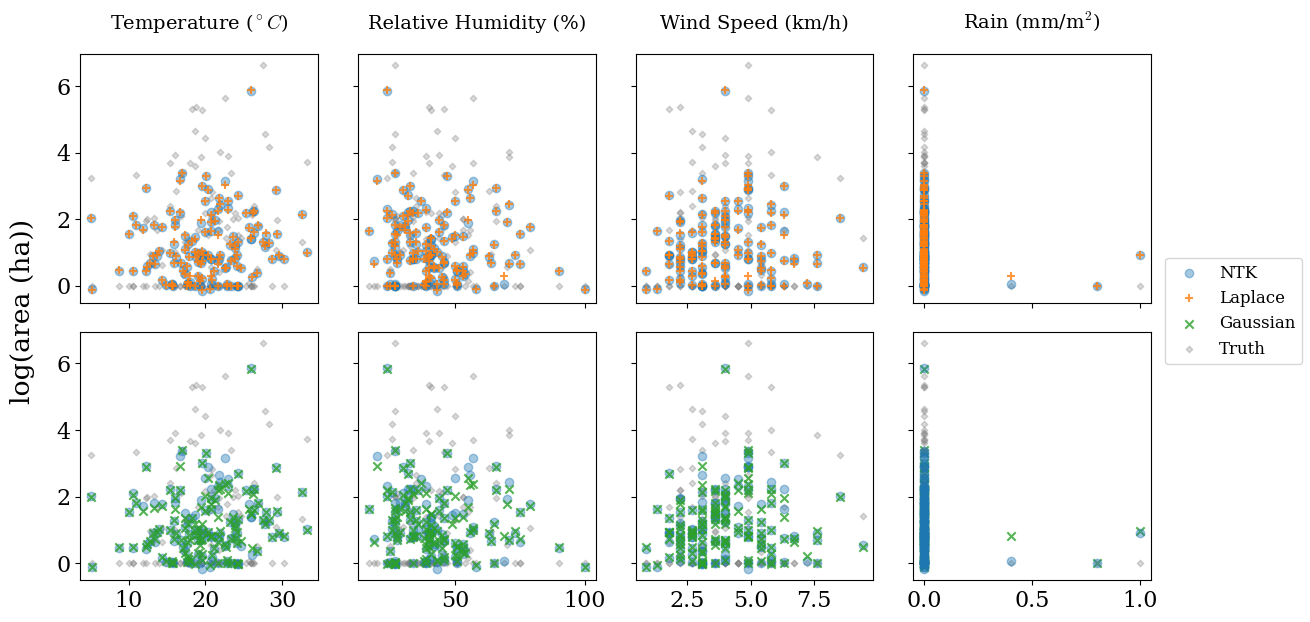

In [133]:
# 

pos = 6
fig, _ = make_plot(pos)

In [134]:
fig.savefig('./exp/real/firesNorm_TNoise_F.svg')